<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Representation_Learning_and_Generative_Learning_Using_Autoencoders_and_GANs.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning and Generative Learning Using Autoencoders and GANs

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from time import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Performing PCA with an Undercomplete Linear Autoencoder

In [5]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape = [3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape = [2]))
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = 'mse', optimizer=keras.optimizers.SGD(lr=1.5))

### Generate 3D data for training

In [6]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [7]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [8]:
history = autoencoder.fit(X_train, X_train, epochs = 20)
coding = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 0s 22ms/step - loss: 0.0932
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0

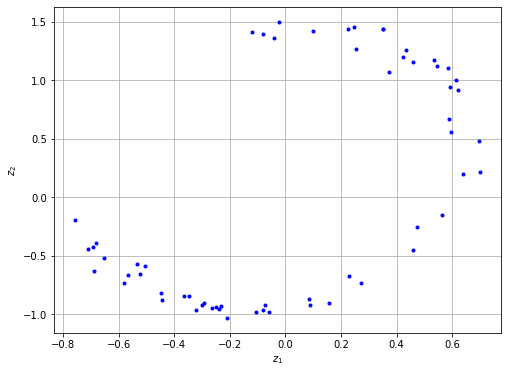

In [9]:
fig = plt.figure(figsize=(8,6))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])    
])

stacked_AE = keras.models.Sequential([stacked_encoder, stacked_decoder])

'''
When compiling the stacked autoencoder, we use the binary cross-entropy 
loss instead of the mean squared error. We are treating the 
reconstruction task as a multilabel binary classification problem: 
each pixel intensity represents the probability that the pixel 
should be black. Framing it this way (rather than as a regression 
problem) tends to make the model converge faster.
'''
stacked_AE.compile(loss='binary_crossentropy', optimizer= keras.optimizers.SGD(lr = 1.5),
                  metrics = [rounded_accuracy])

In [14]:
history = stacked_AE.fit(X_train, X_train, epochs= 20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9007
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9200
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2984 - val_rounded_accuracy: 0.9201
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2913 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [==================

In [24]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [16]:
def show_reconstructions(AE,images=X_valid, n_images=5):
    reconstructions = AE.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

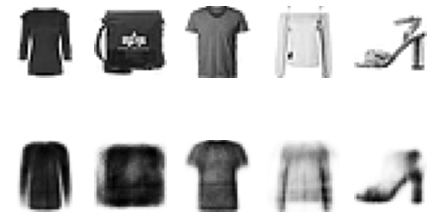

In [17]:
show_reconstructions(stacked_AE)

## Visualizing Fashion MNIST

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets, with many instances and many features. So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization. Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization

In [18]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

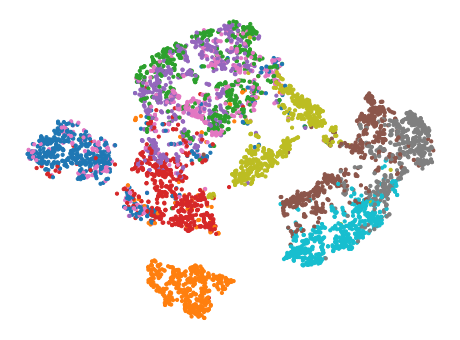

In [19]:
plt.figure(figsize = (8,6))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:,1], c=y_valid, s=10, cmap='tab10')
plt.axis(False)
plt.show()

# Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.


Specifically, if the autoencoder has a total of N layers (not counting the input layer), and $W_L$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer N/2 is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined simply as: $W_{N–L+1} = W_{L^T}$ (with L = 1, 2, …, N/2).

In [20]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = 'bias',
                                      shape = [self.dense.input_shape[-1]],
                                      initializer = 'zeros')
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation = 'selu')
dense_2 = keras.layers.Dense(30, activation = 'selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_AE= keras.models.Sequential([tied_encoder, tied_decoder])
tied_AE.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5), 
               metrics = [rounded_accuracy])

In [22]:
history = tied_AE.fit(X_train, X_train, epochs =10,
                     validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9087
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

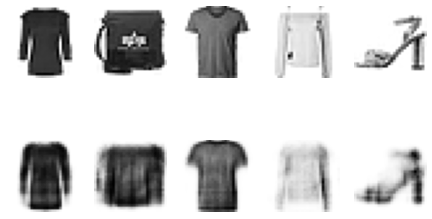

In [23]:
show_reconstructions(tied_AE)

## Training one Autoencoder at a Time

In [24]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                     n_epochs = 10, output_activation = None, metrics = None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation = 'selu', input_shape = [n_inputs]),        
    ])
    
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation = output_activation)        
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics = metrics)
    autoencoder.fit(X_train, X_train, epochs = n_epochs,
                   validation_data = (X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_flat = keras.backend.batch_flatten(X_train)
X_valid_flat = keras.backend.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat,
                                                          'binary_crossentropy',
                                                          keras.optimizers.SGD(lr=1.5),
                                                          output_activation='sigmoid',
                                                          metrics = [rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, 'mse',
                                    keras.optimizers.SGD(lr=0.05),
                                    output_activation = 'selu')

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [26]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

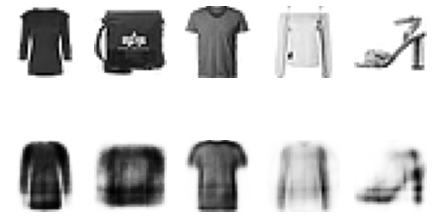

In [27]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [28]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

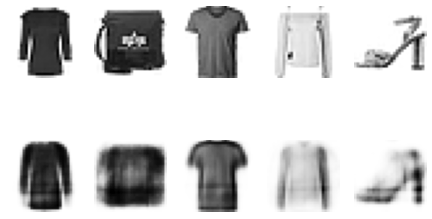

In [29]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

In [30]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                activation='selu',
                                input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

conv_AE = keras.models.Sequential([conv_encoder, conv_decoder])

In [31]:
conv_AE.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_AE.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 48s 28ms/step - loss: 0.3013 - rounded_accuracy: 0.9191 - val_loss: 0.2839 - val_rounded_accuracy: 0.9320
Epoch 2/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2750 - rounded_accuracy: 0.9418 - val_loss: 0.2742 - val_rounded_accuracy: 0.9453
Epoch 3/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2704 - rounded_accuracy: 0.9466 - val_loss: 0.2705 - val_rounded_accuracy: 0.9484
Epoch 4/5
1719/1719 [==============================] - 37s 22ms/step - loss: 0.2680 - rounded_accuracy: 0.9491 - val_loss: 0.2680 - val_rounded_accuracy: 0.9502
Epoch 5/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.2663 - rounded_accuracy: 0.9509 - val_loss: 0.2664 - val_rounded_accuracy: 0.9521


## Recurrent Autoencoders

In [32]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

In [33]:
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [34]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 86s 50ms/step - loss: 0.5146 - rounded_accuracy: 0.7513 - val_loss: 0.4441 - val_rounded_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 82s 48ms/step - loss: 0.3991 - rounded_accuracy: 0.8462 - val_loss: 0.3748 - val_rounded_accuracy: 0.8621
Epoch 3/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3654 - rounded_accuracy: 0.8700 - val_loss: 0.3606 - val_rounded_accuracy: 0.8730
Epoch 4/10
1719/1719 [==============================] - 86s 50ms/step - loss: 0.3528 - rounded_accuracy: 0.8797 - val_loss: 0.3527 - val_rounded_accuracy: 0.8795
Epoch 5/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3425 - rounded_accuracy: 0.8872 - val_loss: 0.3399 - val_rounded_accuracy: 0.8891
Epoch 6/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3345 - rounded_accuracy: 0.8919 - val_loss: 0.3312 - val_rounded_accuracy: 0.8961
Epoch 7/10
1719/1719 [======

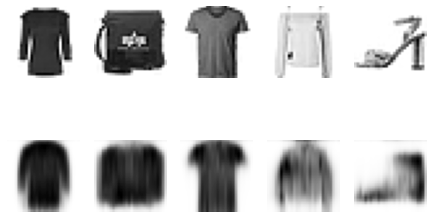

In [35]:
show_reconstructions(recurrent_ae)
plt.show()

## Denoising Autoencoders

In [36]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [37]:
dropout_AE = keras.models.Sequential([
    dropout_encoder, dropout_decoder
])

In [38]:
dropout_AE.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr = 1.0), metrics=[rounded_accuracy])
history = dropout_AE.fit(X_train, X_train, epochs = 10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3581 - rounded_accuracy: 0.8708 - val_loss: 0.3224 - val_rounded_accuracy: 0.9023
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3196 - rounded_accuracy: 0.9019 - val_loss: 0.3131 - val_rounded_accuracy: 0.9088
Epoch 3/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3139 - rounded_accuracy: 0.9063 - val_loss: 0.3092 - val_rounded_accuracy: 0.9131
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3105 - rounded_accuracy: 0.9090 - val_loss: 0.3066 - val_rounded_accuracy: 0.9162
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3078 - rounded_accuracy: 0.9112 - val_loss: 0.3033 - val_rounded_accuracy: 0.9178
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3058 - rounded_accuracy: 0.9129 - val_loss: 0.3022 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==========

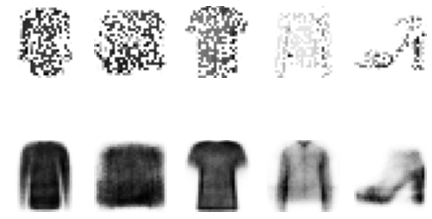

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.Dropout(0.5)
show_reconstructions(dropout_AE, noise(X_valid, training=True))
plt.show()

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [41]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3174 - val_rounded_accuracy: 0.9052
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9121
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

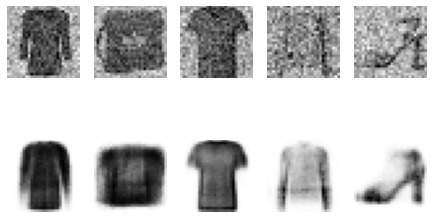

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

## Sparse Autoencoders

In [43]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(300, activation = 'sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28,28])
])

sparse_l1_AE = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [44]:
sparse_l1_AE.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr =1.0), metrics=[rounded_accuracy])
sparse_l1_AE.fit(X_train, X_train, epochs = 10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

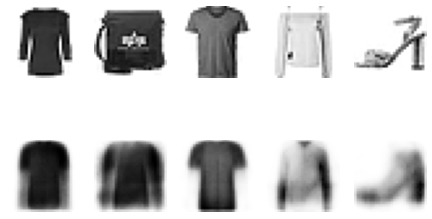

In [45]:
show_reconstructions(sparse_l1_AE)

## Generative Adversarial Networks

In [39]:
coding_size = 10

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = [coding_size]),
    keras.layers.Dense(150, activation = 'selu'),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28,28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dense(150, activation = 'selu'),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

Next, we need to compile these models. As the discriminator is a binary classifier, we can naturally use the binary cross-entropy loss. The generator will only be trained through the gan model, so we do not need to compile it at all. The gan model is also a binary classifier, so it can use the binary cross-entropy loss. Importantly, the discriminator should not be trained during the second phase, so we make it non-trainable before compiling the gan model:

In [40]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

### Note

The trainable attribute is taken into account by Keras only when compiling a model, so after running this code, the discriminator is trainable if we call its fit() method or its train_on_batch() method (which we will be using), while it is not trainable when we call these methods on the gan model.

Since the training loop is unusual, we cannot use the regular fit() method. Instead, we will write a custom training loop. For this, we first need to create a Dataset to iterate through the images:

In [41]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

We are now ready to write the training loop. Let’s wrap it in a train_gan() function:

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        start = time.time()
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown
        print(f"Duration {time.time() - start} s")

In [ ]:
train_gan(gan, dataset, batch_size, coding_size, epochs = 1)

In [25]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

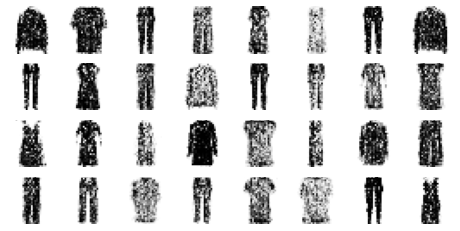

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, coding_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

## Deep Convolutional GANs

he original GAN paper in 2014 experimented with convolutional layers, but only tried to generate small images. Soon after, many researchers tried to build GANs based on deeper convolutional nets for larger images. This proved to be tricky, as training was very unstable, but Alec Radford et al. finally succeeded in late 2015, after experimenting with many different architectures and hyperparameters. They called their architecture deep convolutional GANs (DCGANs). Here are the main guidelines they proposed for building stable convolutional GANs:

    Replace any pooling layers with strided convolutions (in the discriminator) and transposed convolutions (in the generator).

    Use Batch Normalization in both the generator and the discriminator, except in the generator’s output layer and the discriminator’s input layer.

    Remove fully connected hidden layers for deeper architectures.

    Use ReLU activation in the generator for all layers except the output layer, which should use tanh.

    Use leaky ReLU activation in the discriminator for all layers.

These guidelines will work in many cases, but not always, so you may still need to experiment with different hyperparameters (in fact, just changing the random seed and training the same model again will sometimes work). For example, here is a small DCGAN that works reasonably well with Fashion MNIST:

In [28]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape = [codings_size]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size =5, strides = 2, padding = 'same',
                       activation = keras.layers.LeakyReLU(0.2),
                       input_shape = [28,28,1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides = 2, padding='same',
                       activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [29]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [30]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [31]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

-------------------------
Epoch No 1
Duration : 162.8050549030304
-------------------------
-------------------------
Epoch No 2
Duration : 150.44806957244873
-------------------------
-------------------------
Epoch No 3
Duration : 150.41912817955017
-------------------------
-------------------------
Epoch No 4


KeyboardInterrupt: 

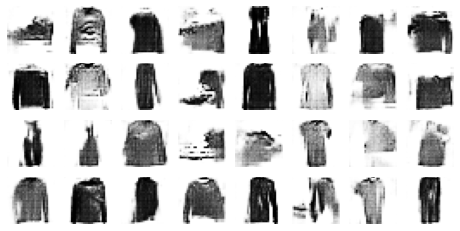

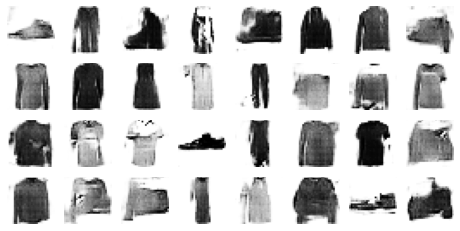

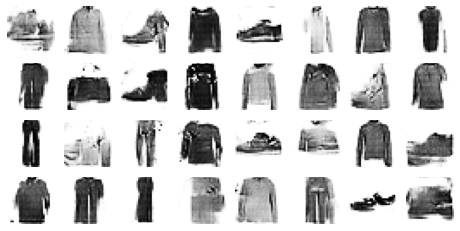

In [33]:
train_gan(gan, dataset, batch_size, codings_size)